Seed set to: 549019528
Initial v:  Parameter containing:
tensor([2.], requires_grad=True)
Epoch 1, L2 Relative Error: 1.0615049410838777, v: 1.9978361627009005
  loss: 57.894468
Epoch 1000, L2 Relative Error: 0.07770182083300073, v: 1.738912576617928
  loss: 1.127246
Epoch 2000, L2 Relative Error: 0.04739265866576112, v: 1.3937898529906054
  loss: 0.730377
Epoch 3000, L2 Relative Error: 0.07132333056937007, v: 1.1377635174819116
  loss: 0.439398
Epoch 4000, L2 Relative Error: 0.056885557532082194, v: 1.0290924131822992
  loss: 0.284810
Epoch 5000, L2 Relative Error: 0.052302638726065276, v: 1.005624519006924
  loss: 0.220042
Epoch 6000, L2 Relative Error: 0.04189650206391125, v: 1.001937193264994
  loss: 0.146566
Epoch 7000, L2 Relative Error: 0.03938842547814933, v: 1.0000585459604396
  loss: 0.163409
Epoch 8000, L2 Relative Error: 0.033809645958089475, v: 1.0025590920630008
  loss: 0.086718
Epoch 9000, L2 Relative Error: 0.02902982783245989, v: 1.0034306183899382
  loss: 0.086353
Epo

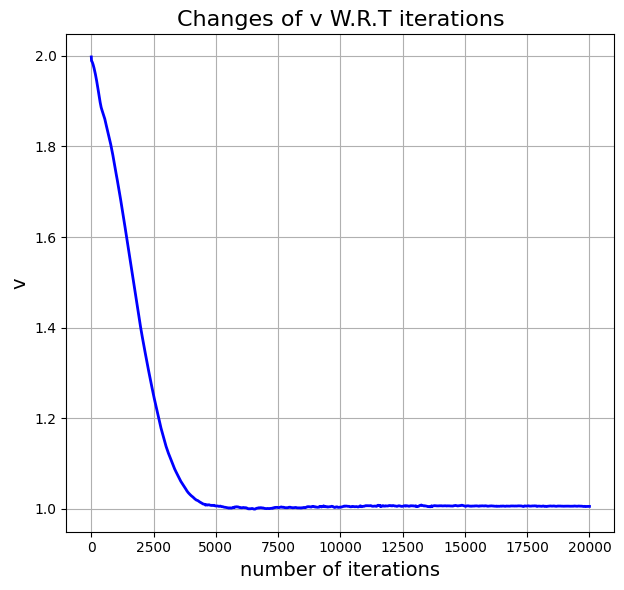

In [1]:
#BCE loss (v1_v2)
import torch
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

sin = torch.sin
cos = torch.cos
exp = torch.exp
pi = torch.pi
torch.set_default_dtype(torch.float64)

epochs = 20000  # iterations
h = 100  # Test point grid density
N = 2000  # interior points
N1 = 100  # boundary points
N2 = 200  # data points

x = np.linspace(-3, 3,10)
y= np.linspace(-3, 3,10)  # 例如，x 从 0 到 2π  # 例如，x 从 0 到 2π
t = np.linspace(0, 1, 20)          # t 从 0 到 10，共 200 个时间点



def setup_seed(seed=None):
    if seed is None:
        seed = torch.randint(0, 2**32 - 1, (1,)).item()  # Generate a random seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    print(f"Seed set to: {seed}")
    return seed

setup_seed()
def gen_testdata():


    xx, yy, tt = np.meshgrid(x, y, t)


    usol = np.sin(2 * xx + tt)  # shape: (len(y), len(x), len(t))


    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
    z = usol.flatten()[:, None]

    return X, z

def l2_relative_error(z_true, z_pred):
    return np.linalg.norm(z_true - z_pred) / np.linalg.norm(z_true)

# Domain and Sampling
def interior(n=N):
    # sampling x∈[-3,3], y∈[-3,3], t∈[0,1]
    x = torch.rand(n, 1)*6 - 3  # [-3,3]
    y = torch.rand(n, 1)*6 - 3  # [-3,3]
    t = torch.rand(n, 1)        # [0,1]
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def ini(n=N1):
    # IC t=0
    x = torch.rand(n, 1)*6 - 3
    y = torch.rand(n, 1)*6 - 3
    t = torch.zeros_like(x)
    cond = torch.sin(2 * x)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def left(n=N1):
    # BC u(-3,y,t)=0
    t = torch.rand(n, 1)
    x = -3 * torch.ones_like(t)
    y = torch.rand(n, 1)*6 - 3
    cond = torch.sin(-6+t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def right(n=N1):
    # BC u(3,y,t)=0
    t = torch.rand(n, 1)
    x = 3 * torch.ones_like(t)
    y = torch.rand(n, 1)*6 - 3
    cond = torch.sin(6+t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def up(n=N1):
    # BC u(x,3,t)=0
    t = torch.rand(n, 1)
    y = 3 * torch.ones_like(t)
    x = torch.rand(n, 1)*6 - 3
    cond = torch.sin(2*x+t)
    return x.requires_grad_(True), y.requires_grad_(True),t.requires_grad_(True), cond

def down(n=N1):
    # BC u(x,-3,t)=0
    t = torch.rand(n, 1)
    y = -3 * torch.ones_like(t)
    x = torch.rand(n, 1)*6 - 3
    cond = torch.sin(2*x+t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def data_interior(n=N2):
    # data
    X, Y = gen_testdata()
    ids = np.random.randint(X.shape[0], size=n)
    xy_t = X[ids]
    u_real = Y[ids]
    xy_t = torch.from_numpy(xy_t)
    cond = torch.from_numpy(u_real)
    xy_t.requires_grad_(True)
    return xy_t, cond

# Neural Network
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),  # input x,y,t
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
        )


    def forward(self, x):
        return self.net(x)

# Loss functions
loss = torch.nn.MSELoss()


def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                 create_graph=True,
                                 only_inputs=True)[0]
    else:
        return gradients(gradients(u, x), x, order=order-1)

# Initialize two parameters v1 and v2
v = torch.nn.Parameter(torch.tensor([2.0]), requires_grad=True)
print('Initial v: ', v)
def l_interior(u):
    x, y, t, cond = interior()
    u_val = u(torch.cat([x, y, t], dim=1))  # 直接接收单个返回值
    u_t = gradients(u_val, t, 1)
    u_x = gradients(u_val, x, 1)
    u_y = gradients(u_val, y, 1)
    u_xx = gradients(u_val, x, 2)
    u_yy = gradients(u_val, y, 2)
    r = torch.sqrt(x**2 + y**2)

    residual = u_t - 6*u_val*(u_x**2+u_y**2)-3*(u_val**2)*(u_xx + u_yy) - v* cos(2*x+t) + 24 * sin(2*x+t)*cos(2*x+t)**2 - 12*sin(2*x+t)**3
    return loss(residual, cond)

def l_ini(u):
    # IC loss
    x, y, t, cond = ini()
    u_val= u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_left(u):
    # BC loss
    x, y, t, cond = left()
    u_val= u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_right(u):
    # BC loss
    x, y, t, cond = right()
    u_val= u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_up(u):
    # BC loss
    x, y, t, cond = up()
    u_val= u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_down(u):
    # BC loss
    x, y, t, cond = down()
    u_val= u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_data(u):
    xyt, cond = data_interior()
    u_pred = u(xyt)
    return loss(u_pred, cond)

# Training
u = MLP()
opt = torch.optim.RAdam(list(u.parameters()) + [v], lr=1e-3)

scheduler = StepLR(opt, step_size=1000, gamma=0.9)
# record training
L2_error = []
v_values = []
iterations = []

# obtain training data
xy_t, u_real = gen_testdata()
xy_t = torch.from_numpy(xy_t)

for i in range(epochs):
    opt.zero_grad()
    l_i = l_interior(u)
    l_d = l_data(u)
    l_initial = l_ini(u)
    l_u = l_up(u)
    l_dn = l_down(u)
    l_l = l_left(u)
    l_r = l_right(u)

    # loss function
    l = l_i + l_initial + l_dn + l_u + l_l + l_r + 10*l_data(u)
    l.backward()
    torch.nn.utils.clip_grad_norm_(u.parameters(), 0.1)

    opt.step()
    scheduler.step()


    # record
    v_values.append(v.item())
    iterations.append(i+1)

    if (i+1) % 1000 == 0 or i == 0:
        u_pred= u(xy_t)
        error = l2_relative_error(u_real, u_pred.detach().numpy())
        L2_error.append(error)
        print(f"Epoch {i+1}, L2 Relative Error: {error}, v: {v.item()}")
        print(f"  loss: {l.item():.6f}")
print('Final v: ', v)



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations, v_values, 'b-', linewidth=2)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('v', fontsize=14)
plt.title('Changes of v W.R.T iterations', fontsize=16)
plt.grid(True)


plt.tight_layout()
plt.show()
#seed 549019528